In [1]:
import numpy as np
import sys
sys.path.append("../")
from mlp import mlp
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.preprocessing import scale
import datetime
import pickle

## Remap function REDO 

In [2]:
def remap(X, converted_array=None, inv=False):
    if inv:
        return (converted_array * (X.max() - X.min()) + X.min()) * 1000.
    else:
        return(X - X.min())/(X.max() - X.min())/1000.

## Loading data
### Remember that 1 means PD

In [3]:
data = pd.read_csv("../dataset/parkinsons.data")
data.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


## Defining X and y

In [4]:
c = 0
for i in data.columns:
    print c, i 
    c+=1

0 name
1 MDVP:Fo(Hz)
2 MDVP:Fhi(Hz)
3 MDVP:Flo(Hz)
4 MDVP:Jitter(%)
5 MDVP:Jitter(Abs)
6 MDVP:RAP
7 MDVP:PPQ
8 Jitter:DDP
9 MDVP:Shimmer
10 MDVP:Shimmer(dB)
11 Shimmer:APQ3
12 Shimmer:APQ5
13 MDVP:APQ
14 Shimmer:DDA
15 NHR
16 HNR
17 status
18 RPDE
19 DFA
20 spread1
21 spread2
22 D2
23 PPE


In [5]:
print "total PD", data.status.values.tolist().count(1)
print "total no PD", data.status.values.tolist().count(0)
# as the number of PD and no PD is hugely different, resampling to get even amounts
pd_index = data.index[data.loc[:, "status"]==1]
nopd_index = data.index[data.loc[:, "status"]==0]
print pd_index.shape
print nopd_index.shape
#making data more even
my_index = np.hstack((pd_index[:48], nopd_index))
print my_index.shape

total PD 147
total no PD 48
(147,)
(48,)
(96,)


In [6]:
X = data.values[my_index, 1:].astype(np.float64)
X_scaled = scale(data.values[my_index, 1:].astype(np.float64)) #data[data.columns[[1, 2, 3]]].values
y = data.status.values.astype(np.float64)[my_index]#.reshape(-1,1)
print X.shape, y.shape

(96, 23) (96,)


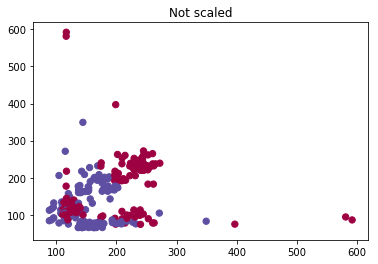

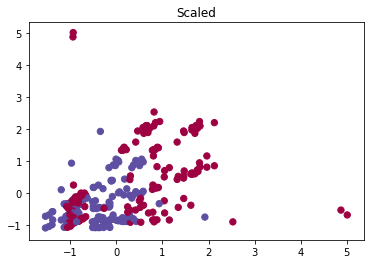

In [7]:
X_data =  X[:, [0, 1,2]].astype(np.float64)#X[:, [22, 19, 0, 1]] #X[:, [22, 21, 20, 19]]  #X[:, [0,1,2]] 

plt.scatter(X_data[:,0], X_data[:,1], s=40, c=y, cmap=plt.cm.Spectral)
plt.scatter(X_data[:,0], X_data[:,2], s=40, c=y, cmap=plt.cm.Spectral)

plt.scatter(X_data[:,1], X_data[:,2], s=40, c=y, cmap=plt.cm.Spectral)
plt.title("Not scaled")
plt.show()


#######################   SCALED    ##########################




X_data_sc =  X_scaled[:, [0, 1,2]].astype(np.float64)#X[:, [22, 19, 0, 1]] #X[:, [22, 21, 20, 19]]  #X[:, [0,1,2]] 

plt.scatter(X_data_sc[:,0], X_data_sc[:,1], s=40, c=y, cmap=plt.cm.Spectral)
plt.scatter(X_data_sc[:,0], X_data_sc[:,2], s=40, c=y, cmap=plt.cm.Spectral)

plt.scatter(X_data_sc[:,1], X_data_sc[:,2], s=40, c=y, cmap=plt.cm.Spectral)
plt.title("Scaled")
plt.show()

## Training and validating

CPU times: user 1.2 s, sys: 2.8 ms, total: 1.21 s
Wall time: 1.21 s
Training Error:  23.999482166
Validation Score:  0.952038496502
Validation R2score:  0.996003208042


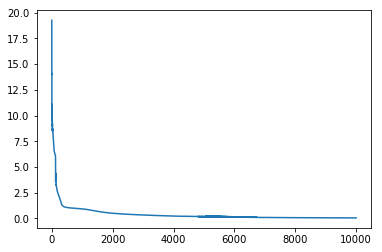

0.999893247346 1.0
1.0 1.0
0.999999802198 1.0
0.99999999996 1.0
0.999999999248 1.0
0.880495174254 1.0
0.999999999978 1.0
0.955699234743 1.0
0.999999969738 1.0
0.999999999952 1.0
0.999999999951 1.0
0.999999999724 1.0
0.99999988 1.0
0.999999833183 1.0
0.999998594957 1.0
0.992686423515 1.0
0.985513868288 1.0
0.989317039391 1.0
0.999999999472 1.0
1.0 1.0
0.999999998133 1.0
0.999999998199 1.0
0.999999981868 1.0
0.987600144349 1.0
0.999999996858 1.0
0.99999997886 1.0
0.999948694376 1.0
0.999999988937 1.0
0.99992868452 1.0
0.999999998131 1.0
0.999989320269 1.0
0.999986431864 1.0
0.999956182943 1.0
0.989384717505 1.0
0.99914238843 1.0
0.999785095304 1.0
0.953602937688 1.0
0.998948391727 1.0
0.996552789156 1.0
0.99564175253 1.0
0.829083394763 1.0
0.999999976084 1.0
0.999998924254 1.0
0.999998704607 1.0
0.99999991915 1.0
0.999999989876 1.0
0.999999884691 1.0
0.999999816529 1.0
0.000602970621279 0.0
0.000117099367439 0.0
0.000109851382986 0.0
2.7446081328e-05 0.0
2.96354333734e-05 0.0
3.814054380

In [41]:
clf = mlp(seed=0, activation="sigmoid", max_iter=10000, 
          hidden_layer_size=15, alpha=0.11, momentum=0.9, 
          tol=1e-10, weight_range=(-1,1), bias=True, classifier=False)

%time clf.fit(X_data_sc, y)
print "Training Error: ", 1 - clf.score(X_data, y)

pred =  clf.predict(X_data_sc)
 
print "Validation Score: ", clf.score(X_data_sc, y) 
print "Validation R2score: ", r2_score(y, pred)

%matplotlib inline
plt.plot(clf.error_list)
#plt.ylim(0, 15)
plt.show()
pred = clf.predict(X_data_sc)
for i in xrange(pred.shape[0]):
    print pred[i,0], y[i]

### Saving to file

In [10]:
if 0:
    f = open("pd.mlp", "w")
    f.write(pickle.dumps(clf))
    f.close()
else:
    print "Not saved"

Not saved


## Genetic Algorithm

In [501]:
class genetic_improver():

    def __init__(self, mlp, example_population, already_scaled=True, population_size=100,
                 class_a_to_b_prop=0.5, crossover_rate=0.5, mutate_rate=0.1, 
                 total_generations=1000, verbose=False, seed=None):
        
        self.mlp = mlp # the instace of the MLP already traine
        self.already_scaled = already_scaled
        self.population = None
        self.population_size = population_size
        self.crossover_rate = crossover_rate
        self.total_generations = total_generations
        self.verbose = verbose
        self.seed = seed
        
        #general purpose variables
        self._rank = None
        self.fitness_array = None
        self.my_max = np.amax(example_population, axis=0)
        self.my_min = np.amin(example_population, axis=0)
        self.to_mutate_n = int(population_size * mutate_rate)
        self.to_crossover_n = int(crossover_rate * population_size)
        self.inv_to_crossover_n = int(self.population_size - self.to_crossover_n)
        self.class0_number = int(class_a_to_b_prop * population_size)
        
        
    #creates the population    
    def _create_population(self):
        np.random.seed(self.seed)
        #print my_max, my_min
        pop = []
        for mn,mx  in zip(self.my_min, self.my_max):
            pop.append(np.random.normal(mn, mx, (self.population_size)))
        
        self.population = np.abs(np.array(pop).T).round(3) #TODO REDO
     
    
    #calculates the fitness and ranks the population, the closer to zero, the better
    # returns the rank (numbers from best to worst) and the error list sorted ()
    def _get_fitnesses(self, myclass=0):
        
        if self.already_scaled:
            prediction = self.mlp.predict(self.population)[:,0]
        else:
            scaled_pop = scale(self.population)
            prediction = self.mlp.predict(scaled_pop)[:,0]

        #as we want to set the proportions, there are two fitnesses in one
        # half the pop takes one, the other takes the second
        
        if myclass==0:
            rank_not_sorted = np.abs(0. - prediction)
        else:
             rank_not_sorted = np.abs(1. - prediction)
                
        self._rank =  rank_not_sorted.argsort()
        self.fitness_array = np.sort(rank_not_sorted)
        
    # makes the crossover and removes the less fitted (the number of indivuals always stays the same)
    def _crossover(self):
        
        np.random.seed(self.seed)
        
        #print"cross", n_cross, "inv cross" ,inv_n_cross 
        
        # aligning the population to the order of the rank
        self.population = self.population[self._rank]
        #print "\n pop", self.population
        
        #other from all array, to maintain the diversity
        other_elements = np.copy(self._rank)
        np.random.shuffle(other_elements)
        #print "\n shuffle\n", other_elements 
        
        #choosing randomly th point to cross, as it is an odd number
        cross_point = np.random.randint(0,3)
        #print "\n cross point", cross_point
        
        #crossing the bests with the others and removing excessive data
        rand_pop = self.population[other_elements]
        data = np.hstack((self.population[:, :cross_point], rand_pop[:, cross_point:]))
        #print "\n data\n", data
        
        #adding new individuals to end and removing the worst ones
        #print"cross", n_cross, "inv cross" ,inv_n_cross
        
        old_pop = self.population[:self.inv_to_crossover_n, :]
        new_pop = data[:self.to_crossover_n, :]
        #print old_pop.shape, new_pop.shape 
        
        self.population = np.vstack((old_pop, new_pop)) 
        #print "\n pop\n", self.population
    
    # mutates the remaining population
    def _mutate(self):
                
        # no reason to run if not to mutate
        if self.to_mutate_n >0:
            np.random.seed(self.seed)
            my_array = np.copy(self._rank)
            np.random.shuffle(my_array)
            #indivuals to mutate
            mutated_individuals = my_array[:self.to_mutate_n]
            #mutated cromossomes
            mutated_cromossomes = np.random.randint(0,self.population.shape[1], (self.to_mutate_n))

            pop = []
            for mn,mx  in zip(self.my_min, self.my_max):
                pop.append(np.random.normal(mn, mx, (self.to_mutate_n)))
        
            m_pop = np.abs(np.array(pop).T).round(3)[:, mutated_cromossomes][:, 0] #TODO REDO
            #print m_pop
        
            self.population[mutated_individuals, mutated_cromossomes] = m_pop
        
    
    #receives noinput and returns the generated population
    def fit(self):
        
        # generating class 0
        self._create_population()
        if self.verbose:
            print "Finding class A"
        for i in xrange(self.total_generations):
            self._get_fitnesses(myclass=0)
            self._crossover()
            self._mutate()
            if self.verbose:
                print "---> Best: %s"%self.fitness_array[self._rank][0]
        class0 = np.copy(self.population) 
        
        # generating class 1
        if self.verbose:
            print "Finding class B"
        self._create_population()
        for i in xrange(self.total_generations):
            self._get_fitnesses(myclass=1)
            self._crossover()
            self._mutate()
            if self.verbose:
                print "---> Best: %s"%self.fitness_array[self._rank][0]
    
        self.population = np.vstack((class0[:self.class0_number, :], self.population[self.class0_number:, :] ))

In [506]:
a = genetic_improver(clf, X_data, population_size=4, seed=0, already_scaled=False,
                     verbose=True, total_generations=10, crossover_rate=0.5, mutate_rate=0.1)

In [507]:
a._create_population()
#print a.population


a._get_fitnesses(0)
#print "\n", a._rank, a.fitness_array


a._crossover()
print "\n pop\n", a.population


a._mutate()
print "\n pop\n", a.population


 pop
[[  547.172  1217.89     40.789]
 [  671.201    22.632   413.295]
 [  547.172   674.721    99.927]
 [  671.201    22.632   413.295]]

 pop
[[  547.172  1217.89     40.789]
 [  671.201    22.632   413.295]
 [  547.172   674.721    99.927]
 [  671.201    22.632   413.295]]


In [508]:
%time a.fit()

Finding class A
---> Best: 1.56380724799e-18
---> Best: 1.75829094087e-07
---> Best: 0.022177245766
---> Best: 0.022177245766
---> Best: 0.022177245766
---> Best: 0.022177245766
---> Best: 0.022177245766
---> Best: 0.022177245766
---> Best: 0.022177245766
---> Best: 0.022177245766
Finding class B
---> Best: 0.999998084922
---> Best: 0.999999952856
---> Best: 0.99890644621
---> Best: 0.817994458649
---> Best: 1.96287430754e-12
---> Best: 0.817994458649
---> Best: 1.96287430754e-12
---> Best: 0.817994458649
---> Best: 1.96287430754e-12
---> Best: 0.817994458649
CPU times: user 11.8 ms, sys: 2.27 ms, total: 14.1 ms
Wall time: 12 ms


In [505]:
clf.predict(a.population).round(3)

array([[ 0.],
       [ 0.],
       [ 1.],
       [ 1.]])

In [486]:
res = clf.predict(a.population).round(0)
b = scale(a.population)

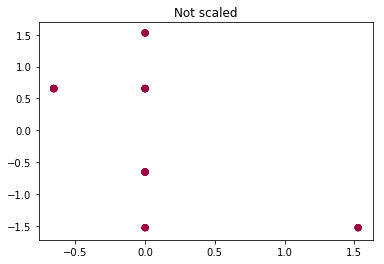

In [487]:
plt.scatter(b[:,0], b[:,1], s=40, c=res, cmap=plt.cm.Spectral)
plt.scatter(b[:,0], b[:,2], s=40, c=res, cmap=plt.cm.Spectral)

plt.scatter(b[:,1], b[:,2], s=40, c=res, cmap=plt.cm.Spectral)
plt.title("Not scaled")
plt.show()

In [45]:
a = [1, 2]
b = [3, 4]
for i, j in zip(a, b):
    print i, j

1 3
2 4


In [72]:
np.random.seed(0)
c = np.random.normal(0,1,(10))

In [182]:
%time d = np.where(1, c>=0.5, 0)

CPU times: user 78 µs, sys: 521 µs, total: 599 µs
Wall time: 2.54 ms


In [82]:
c = np.array([0,1,2,3])

In [80]:
s= np.argsort(c)

In [465]:
s-1

array([ 7,  6,  0,  8,  5,  4,  1, -1,  3,  2])

In [199]:
c[s]

array([-0.97727788, -0.15135721, -0.10321885,  0.40015721,  0.4105985 ,
        0.95008842,  0.97873798,  1.76405235,  1.86755799,  2.2408932 ])

In [70]:
np.random.randint(0,4)

2

In [325]:
np.random.seed(0)
c = np.random.randint(0, 5, size=(4, 3))
d = np.random.randint(0, 5, size=(4, 3))

In [326]:
np.hstack((c,d))

array([[4, 0, 3, 2, 1, 0],
       [3, 3, 1, 1, 1, 0],
       [3, 2, 4, 1, 4, 3],
       [0, 0, 4, 0, 3, 0]])

In [327]:
np.random.shuffle(d)

In [328]:
f = np.array([1, 3, 3, 0])

In [329]:
c

array([[4, 0, 3],
       [3, 3, 1],
       [3, 2, 4],
       [0, 0, 4]])

In [330]:
d

array([[0, 3, 0],
       [1, 1, 0],
       [2, 1, 0],
       [1, 4, 3]])

In [331]:
c[:,np.array([0,1])]=0

In [332]:
c

array([[0, 0, 3],
       [0, 0, 1],
       [0, 0, 4],
       [0, 0, 4]])